# Group Work Project - Computational Finance - Submission 2
# Price a Vanilla European Call Option

In [50]:
# import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [51]:
# Market information
risk_free = 0.08

# Share specific information
S_0 = 100
sigma = 0.3
gamma = 0.75
v_0 = 0.06
kappa = 9
theta = 0.06
rho = -0.4

# Option specific information
strike = 100
T = 1

## 1- Price a vanilla call option under Heston model

In [52]:
# Integral approximation information
t_max = 30
N = 100

# Characteristic function code

a = sigma**2/2

def b(u):
    return kappa-rho*sigma*1j*u

def c(u):
    return -(u**2+1j*u)/2

def d(u):
    return np.sqrt(b(u)**2-4*a*c(u))

def xminus(u):
    return (b(u)-d(u))/(2*a)

def xplus(u):
    return (b(u)+d(u))/(2*a)

def g(u):
    return xminus(u)/xplus(u)

def C(u):
    val = T*xminus(u)-np.log((1-g(u)*np.exp(-d(u)*T))/(1-g(u)))/a
    return 1j*risk_free*T*u+theta*kappa*val

def D(u):
    val1 = 1-np.exp(-d(u)*T)
    val2 = 1-g(u)*np.exp(-d(u)*T)
    return (val1/val2)*xminus(u)

def log_char(u):
    return np.exp(C(u)+D(u)*v_0+1j*u*np.log(S_0))

def adj_char(u):
    return log_char(u-1j)/log_char(-1j)

# Calculating delta_t and constructing t_n
delta_t = t_max / N
from_1_to_N = np.linspace(1, N, N)
t_n = (from_1_to_N - 1/2)*delta_t

# Approximate integral estimates
k_log = np.log(strike)
first_integral = sum((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag*delta_t/t_n)
second_integral = sum((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag*delta_t/t_n)

# Calculate call price
fourier_call_val = S_0*(1/2+first_integral/np.pi)-np.exp(-risk_free*T)*strike*(1/2+second_integral/np.pi)

print(f'Call price Heston model = {fourier_call_val:g}')

Call price Heston model = 13.7349


## 2 - Simulate path for the underlying share using CEV model

In [53]:
def share_path_cev(S_0, r, sigma, gamma, T, N, sample_size):
    '''Generates a share path using CEV model
    
    S_0: float
        Initial share price
        
    r: float
        risk free interest rate
    
    sigma: float
            Stock volatility
            
    gamma: float
        CEV gamma parameter
    
    T: float
        Time to maturity (in years)
    
    N: integer
        Number of discrete steps in the path
       
    sample_size: integer
        Number of sample paths to be simulated
    '''
    dT = T/N
    path = np.ones((N+1, sample_size))*S_0
    sigma_lv = np.ones((N, sample_size))*sigma*path[:-1, :]**(gamma-1)
    Z = norm.rvs(size = (N, sample_size))
    for i in range(1, N):
        path[i:, :] = path[i-1]*np.exp(np.cumsum((r-sigma_lv[i-1:, :]**2/2)
                                                   *dT+sigma_lv[i-1:, :]*np.sqrt(dT)*Z[i-1:, :], axis=0))
        sigma_lv[i:, :] = sigma*path[i:-1, :]**(gamma-1)
    return path

In [54]:
# Set random seed for reproducibility
np.random.seed(17)

# Different sample sizes to be simulated
sample_sizes = range(1000, 51000, 1000)

# Simulate paths for the underlying share using different sample sizes
paths = [share_path_cev(S_0, risk_free, sigma, gamma, T, 12, n) for n in sample_sizes]

## 3 - Price vanilla call option using Monte Carlo method

In [55]:
def discounted_call_payoff(S_T, K, r, T):
    '''Evaluate the discounted call payoff 
    
        Parameters
    ----------------   
    S_T: float
        Terminal share price
   
    K: float
        Option strike price
    
    r: float
        risk free interest rate
    
    T: float
        Time to maturity (in years)
    '''   
    return np.exp(-r*T)*np.maximum(S_T-K, 0)

In [56]:
# Arrays to store estimates values
mccall_estimates = np.zeros(len(sample_sizes))
mccall_se = np.zeros(len(sample_sizes))

# Generate Monte Carlo estimates as a function of sample size
for i in range(len(sample_sizes)):
    terminal_prices = paths[i][-1,:]
    call_values = discounted_call_payoff(terminal_prices, strike, risk_free, T)
    mccall_estimates[i] = call_values.mean()
    mccall_se[i] = call_values.std()/np.sqrt((i+1)*1000)

## 4 - Plot Monte Carlo estimates with 99.7% confidence interval bounds

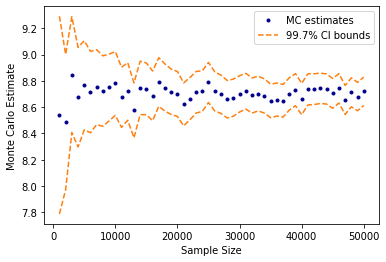

In [57]:
# Plotting the graph
plt.plot(sample_sizes, mccall_estimates, '.', label = 'MC estimates', color = 'darkblue')
plt.plot(sample_sizes, mccall_estimates-3*mccall_se, '--', color = 'C1', label = '99.7% CI bounds')
plt.plot(sample_sizes, mccall_estimates+3*mccall_se, '--', color = 'C1')
plt.xlabel('Sample Size')
plt.ylabel('Monte Carlo Estimate')
plt.legend()
plt.show()

# 5 , 6 - Volatility 

Text(0.5, 1.0, 'Facebook Option Volatility Smile')

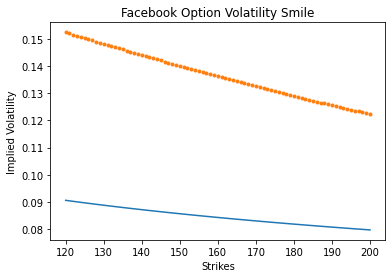

In [58]:
# Market information
# one month T-bill rate - 2.22%

r = 2.22 # https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwigvdac-aj5AhXbjYkEHYIxAOUQFnoECBIQAw&url=https%3A%2F%2Fycharts.com%2Findicators%2F1_month_treasury_rate%23%3A~%3Atext%3D1%2520Month%2520Treasury%2520Rate%2520is%2520at%25202.22%2525%252C%2520compared%2520to%25202.20%2Clong%2520term%2520average%2520of%25201.17%2525.&usg=AOvVaw0GYO67ilStHS_tEjzTL6OZ


# Share specific information
S0 = 160.11
sigma = 0.3
gamma = 0.75
T = 1

# call price under CEV
z = 2+1/(1-gamma)
def C(t, K):
    kappa = 2*r/(sigma**2*(1-gamma)*(np.exp(2*r*(1-gamma)*t)-1))
    x = kappa*S0**(2*(1-gamma))*np.exp(2*r*(1-gamma)*t)
    y = kappa*K**(2*(1-gamma))
    return S0*(1-norm.cdf(y, z, x))-K*np.exp(-r*t)*norm.cdf(x, z-2, y)

# strikes to test volatility
test_strikes = np.linspace(120, 200, 81)

# Estimating partial derivatives
delta_t = 0.01
delta_K = 0.01
dC_dT = (C(T+delta_t, test_strikes) - C(T-delta_t, test_strikes))/(2*delta_t)
dC_dK = (C(T, test_strikes+delta_K)-C(T, test_strikes-delta_K))/(2*delta_K)
d2C_dK2 = (C(T, test_strikes+2*delta_K)-2*C(T, test_strikes+delta_K)+C(T, test_strikes))/(delta_K**2)


# Estimating local volatility - Dupire Equation
vol_est = np.sqrt(2)/test_strikes*np.sqrt((dC_dT+r*test_strikes*dC_dK)/d2C_dK2)


# Plotting closed-form and Dupire equation
plt.plot(test_strikes, sigma*test_strikes**(gamma-1))
plt.plot(test_strikes, vol_est, '.')
plt.xlabel("Strikes")
plt.ylabel("Implied Volatility")
plt.title("Facebook Option Volatility Smile")

# Implied Volatility with Newton Raphson 

In [59]:
test_strike = S0+10
# strike as the current price
K = test_strike
op_price=C(T, K)
print(op_price, S0, K, T, r)

def nr(op_price, S0, K, T, r):
    v = np.sqrt(2*np.pi/T)*op_price/S0
    v_old = v
    print("Initial volatility", v_old)
    for i in range(1, 100):
        d1 = (np.log(S0/K)+(r+0.5*v**2)*T)/(v*np.sqrt(T))
        d2 = d1 - v*np.sqrt(T)
        
        f = S0*norm.cdf(d1)- K*np.exp(-r*T)*norm.cdf(d2)-op_price
        d11 = (v*82*T*np.sqrt(T) - (np.log(S0/K)+(r+v**2/2)*T)*np.sqrt(T))/(v**2*T)
        d22 = d11 - np.sqrt(T)
        
        f1 = S0*norm.pdf(d1)*d11-K*np.exp(-r*T)*norm.pdf(d2)*d22
        
        v = v-f/f1
        
        if(abs(v-v_old)<1e-25):
           break
        v_old = v
            
    return v
imp_vol = nr(op_price, S0, K, T, r)
print(imp_vol)
       

40.419209437161115 160.11 170.11 1 2.22
Initial volatility 0.6327895397752807
nan


C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
C:\Users\gaura\anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  ap